In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# Load the MNIST dataset
mnist = tf.keras.datasets.mnist

# Split the dataset into training and testing sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


In [ ]:
# Normalize the pixel values to the range -1 to 1,no single feature dominates the others due to having a larger scale
X_train = (X_train.astype(np.float32) / 127.5) - 1.0
X_test = (X_test.astype(np.float32) / 127.5) - 1.0

print(X_train[0])

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(type(X_train))
# a single image array (28x28):
print(X_train[0].shape)
#print(X_train[0])

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
<class 'numpy.ndarray'>
(28, 28)


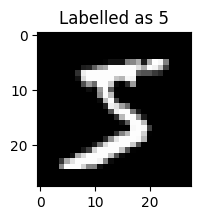

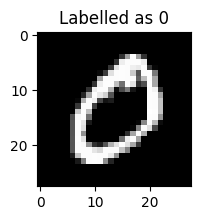

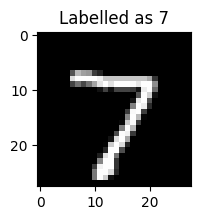

In [6]:
# Extract and display the selected image
def display_dig_img(X_set, y_set, image_index):
  plt.figure(figsize=(2, 2))
  plt.imshow(X_set[image_index], cmap='gray')  # Display the image in grayscale
  plt.title(f"Labelled as {y_set[image_index]}")
  #plt.axis('off')  # Hide axis labels
  plt.show()

display_dig_img(X_train, y_train, 0)
display_dig_img(X_train, y_train, 1)
display_dig_img(X_test, y_test, 0)

In [7]:
# Flatten the original images to 1D,   matrix multiplications,
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
print(X_train_flat.shape)
print(X_test_flat.shape)
#print(X_train_flat[0])

(60000, 784)
(10000, 784)


## **k-Nearest Neighbors**

In [8]:
#Perform digit selection for a classification task-filtering

#Define selected digits for classification
selected_digits = [0,1,2,3,4,5,6,7,8,9]

# Filter training data for the selected digits
selected_indices_train = np.isin(y_train, selected_digits)
X_train_selected = X_train_flat[selected_indices_train]
y_train_selected = y_train[selected_indices_train]

# Filter test data for the selected digits
selected_indices_test = np.isin(y_test, selected_digits)
X_test_selected = X_test_flat[selected_indices_test]
y_test_selected = y_test[selected_indices_test]

In [9]:
from sklearn.metrics import accuracy_score
# Function to predict using k-nearest neighbors algorithm


def knn_predict(x_test, x_train, y_train, k): # set the parameters.1
    predictions = []

    #for loop to go through all the images test data
    for test_point in x_test:

          #Euclidean.2
        distances = np.sqrt(np.sum((x_train - test_point)**2, axis=1))

          #Sort.3
        k_nearest_indices = np.argsort(distances)[:k]

          #Get labels.4
        k_nearest_labels = y_train[k_nearest_indices]

          # Predict the label.5
        predicted_label = np.argmax(np.bincount(k_nearest_labels))

          #appended predictions list.6
        predictions.append(predicted_label)

    return np.array(predictions)

# setting the hyperparameter
k=7

# Make predictions using certain number of neighbors.7
predictions = knn_predict(X_test_selected, X_train_selected, y_train_selected, k)

# Accuracy
accuracy = accuracy_score(y_test_selected, predictions) * 100
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 96.94%


In [10]:
from sklearn.metrics import classification_report

# Calculate precision, recall, and F1-score for each class
class_report = classification_report(y_test_selected, predictions)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.95      1.00      0.97      1135
           2       0.98      0.96      0.97      1032
           3       0.97      0.97      0.97      1010
           4       0.98      0.96      0.97       982
           5       0.97      0.97      0.97       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.99      0.94      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



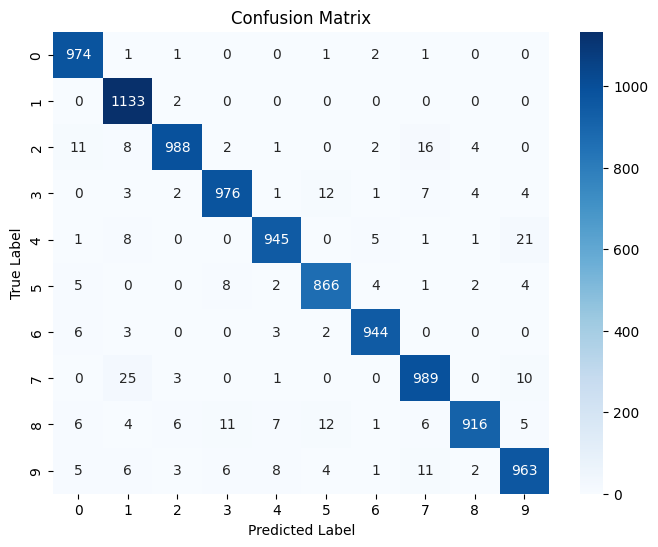

In [11]:
# k-NN Confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_selected, predictions, labels=selected_digits)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=selected_digits, yticklabels=selected_digits)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



## **Naive Bayesian Classification on original data**

In [12]:
#Naive Bayesian Classification on original data
from collections import defaultdict

#Create class and calculate the feature and class probabilities.1
class NaiveBayesClassifier:
    def __init__(self):
        self.class_probabilities = defaultdict(float)
        self.feature_probabilities = defaultdict(lambda: defaultdict(float))

# Determine the number of samples and features in the dataset (X) and identify unique classes in the target variable (y).2
    def train(self, X, y):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)

        # Calculate class probabilities for dataset's class distribution.3
        for cls in unique_classes:
            class_samples = X[y == cls]
            self.class_probabilities[cls] = len(class_samples) / num_samples

            # Calculate feature probabilities for each value observed.4
            for feature_index in range(num_features):
                feature_values = class_samples[:, feature_index]
                unique_values, counts = np.unique(feature_values, return_counts=True)
                for value, count in zip(unique_values, counts):
                    self.feature_probabilities[cls][(feature_index, value)] += (count + 1) / (len(class_samples) + len(unique_values))



   #Create a function Predict the class for each sample in the given dataset (X).5
    def predict(self, X):
        predictions = []

      #Iterate through each sample in the dataset (X).6
        for sample in X:
            max_prob = float('-inf')# Initializing the maximum probability
            predicted_class = None# Initializing the predicted class

         # Calculate the initial probability using class probabilities.7
            for cls, class_prob in self.class_probabilities.items():
                prob = np.log(class_prob)

        #Update the probability using feature probabilities with Laplace smoothing for unseen values .8
                for feature_index, feature_value in enumerate(sample):
                    prob += np.log(self.feature_probabilities[cls][(feature_index, feature_value)] + 1e-10)

          # Determine the class with the highest probability for the current sample.9
                if prob > max_prob:
                    max_prob = prob
                    predicted_class = cls
            predictions.append(predicted_class)
        return predictions

    def accuracy(self, y_true, y_pred):
        return np.mean(y_true == y_pred)

# Instantiate the classifier
nb_classifier = NaiveBayesClassifier()

# Train the classifier
nb_classifier.train(X_train_flat, y_train)

# Make predictions on test data
predictions = nb_classifier.predict(X_test_flat)

# Calculate accuracy
acc = nb_classifier.accuracy(y_test, predictions)
print(f"Accuracy: {acc * 100:.2f}%")



Accuracy: 82.44%


In [13]:
from sklearn.metrics import classification_report

# Calculate precision, recall, and F1-score for each class
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       980
           1       0.99      0.90      0.94      1135
           2       0.81      0.85      0.83      1032
           3       0.76      0.83      0.79      1010
           4       0.80      0.79      0.79       982
           5       0.73      0.70      0.72       892
           6       0.89      0.88      0.89       958
           7       0.92      0.81      0.86      1028
           8       0.70      0.76      0.73       974
           9       0.75      0.80      0.77      1009

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.83     10000



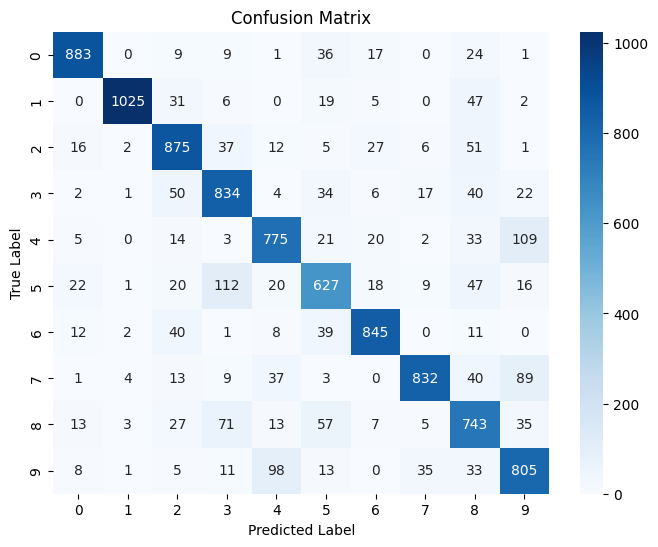

In [14]:
from sklearn.metrics import confusion_matrix

unique_classes = np.unique(y_test)
combined_conf_matrix = np.zeros((len(unique_classes), len(unique_classes)), dtype=int)

for i, true_cls in enumerate(unique_classes):
    cls_indices = y_test == true_cls
    cls_predictions = np.array(predictions)[cls_indices]
    cls_labels = y_test[cls_indices]

    cls_conf_matrix = confusion_matrix(cls_labels, cls_predictions, labels=unique_classes)
    combined_conf_matrix[i, :] = cls_conf_matrix[i, :]

# Display the combined confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(combined_conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


## **Analytical Visualization of the Algorithms performance**

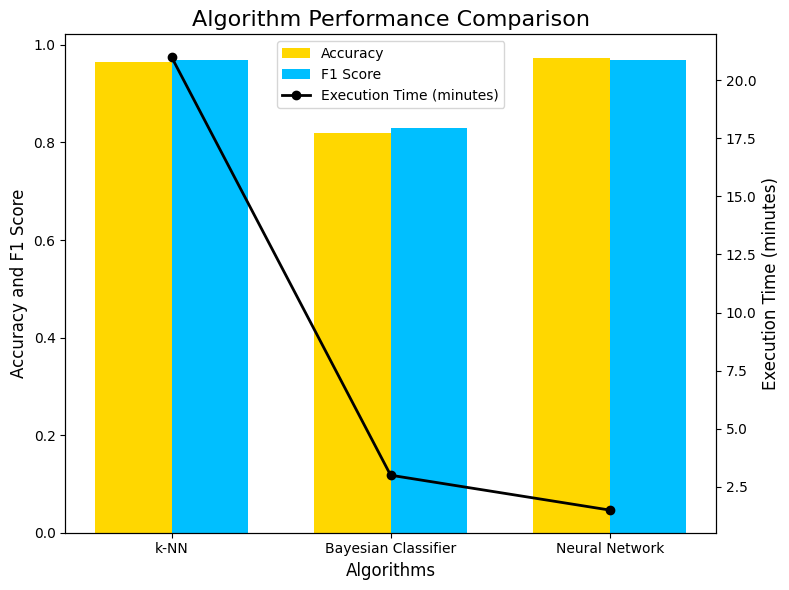

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Data
algorithms = ['k-NN', 'Bayesian Classifier', 'Neural Network']
accuracy = [0.964, 0.82, 0.973]
f1_score = [0.97, 0.83, 0.97]
time_taken = [21, 3, 1.5]  # in minutes

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plotting accuracy and F1 score
width = 0.35  # Width of each bar
x = np.arange(len(algorithms))  # Generate x-axis locations

bars_acc = ax1.bar(x - width/2, accuracy, color='gold', label='Accuracy', width=width)
bars_f1 = ax1.bar(x + width/2, f1_score, color='deepskyblue', label='F1 Score', width=width)

ax1.set_ylabel('Accuracy and F1 Score', color='black', fontsize=12)
ax1.tick_params('y', colors='black')

# Creating the second y-axis for time taken
ax2 = ax1.twinx()
ax2.plot(algorithms, time_taken, color='black', marker='o', linewidth=2, label='Execution Time (minutes)')
ax2.set_ylabel('Execution Time (minutes)', color='black', fontsize=12)
ax2.tick_params('y', colors='black')

# Title and labels
plt.title('Algorithm Performance Comparison', fontsize=16)
ax1.set_xlabel('Algorithms', fontsize=12)
plt.xticks(x, algorithms, fontsize=10)
plt.yticks(fontsize=10)

# Adding legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper center', fontsize=10)

plt.tight_layout()
plt.show()
